## Libraries

In [124]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import random

import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
from sklearn.metrics import average_precision_score
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler,EarlyStopping


## Data Exploration

In [46]:
images = np.array([])
image_list = []
for files in os.listdir("D:\Projects\GenAI\Dataset\VOCdevkit\VOC2008\JPEGImages"):
    filepath = os.path.join("D:\Projects\GenAI\Dataset\VOCdevkit\VOC2008\JPEGImages",files)
    image_list.append(filepath)
    img = cv2.imread(filepath)
    img = cv2.resize(img,(200,200))
    if images.size>0:
        images = np.append(images,[img],axis=0)
    else:
        images = np.expand_dims(img,axis=0)
    

In [49]:
images.shape

(5096, 200, 200, 3)

In [34]:
#Training Data

In [50]:
def get_labels(filepath):
    data_list=[]
    with open(filepath, 'r') as file:
        for line in file:
            filename, label = line.strip().split()

            label = int(label)
            if label == -1 :
                label = 0

            data_list.append([filename, label])

    return data_list

In [51]:
label_files = []
for files in os.listdir("D:\Projects\GenAI\Dataset\VOCdevkit\VOC2008\ImageSets\Main"):
    filepath = os.path.join("D:\Projects\GenAI\Dataset\VOCdevkit\VOC2008\ImageSets\Main",files)
    if filepath.endswith('_train.txt'):
        label_files.append([files,get_labels(filepath)])


In [160]:
# Checking Aero Plane Data for Exploration

In [102]:
aeroplane_list = label_files[0]
label_mapping = dict(aeroplane_list[1])
matched_data = [(image, label_mapping.get(image.split('\\')[-1].split('.')[0], None)) for image in image_list if label_mapping.get(image.split('\\')[-1].split('.')[0], None) is not None]
X_train = np.array([images[image_list.index(pair[0])] for pair in matched_data])
y_train = np.array([pair[1] for pair in matched_data])

In [103]:
X_train.shape,y_train.shape

((2111, 200, 200, 3), (2111,))

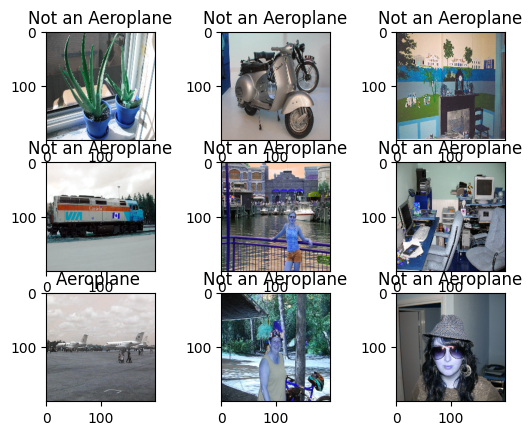

In [56]:
display = 10
for i in range(1,display):
    j = random.randint(0,2110)
    plt.subplot(3,3,i)
    plt.imshow(X_images[j])
    plt.title("Aeroplane " if Y_labels[j] else "Not an Aeroplane")

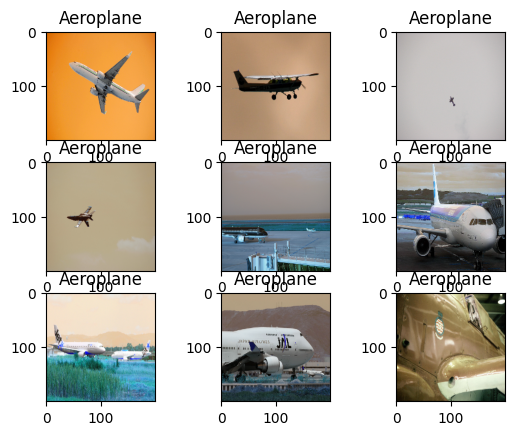

In [57]:
aeroplane_found_indices = np.where(Y_labels == 1)[0]

num_images_to_display = min(len(aeroplane_found_indices), 9)

for i, j in enumerate(aeroplane_found_indices[:num_images_to_display]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_images[j])
    plt.title("Aeroplane" if Y_labels[j] else "Not an Aeroplane")
    if i + 1 >= num_images_to_display:
        break

plt.show()

In [36]:
## Testing Data (Using Validation Data for Testing)

In [104]:
testing = []
for files in os.listdir("D:\Projects\GenAI\Dataset\VOCdevkit\VOC2008\ImageSets\Main"):
    filepath = os.path.join("D:\Projects\GenAI\Dataset\VOCdevkit\VOC2008\ImageSets\Main",files)
    if filepath.endswith('_val.txt'):
        testing.append([files,get_labels(filepath)])


In [105]:
aeroplane_val = testing[0]
label_mapping = dict(aeroplane_val[1])

matched_data = [(image, label_mapping.get(image.split('\\')[-1].split('.')[0], None)) for image in image_list if label_mapping.get(image.split('\\')[-1].split('.')[0], None) is not None]

X_test = np.array([images[image_list.index(pair[0])] for pair in matched_data])
y_test = np.array([pair[1] for pair in matched_data])


## Training 

In [99]:
X_train = np.array([tf.image.resize(image, (200, 200)).numpy() for image in X_train])

In [117]:
#Data Augmentation (Because label 1 images are so less we will use data augmentation to balance class ratio)

batch_size = 16

datagen = ImageDataGenerator(
    rotation_range=15, 
    width_shift_range=0.1, 
    height_shift_range=0.1,  
    horizontal_flip=True,  
    zoom_range=0.1,  
    fill_mode='nearest'  
)

def augment_images(X, y, batch_size):
    augmented_data_X = X.copy()
    augmented_data_y = y.copy()
    
    # Generate augmented data for class 1 images
    for i in range(len(X)):
        if y[i] == 1:
            img = np.expand_dims(X[i], axis=0)  # Add batch dimension
            for batch in datagen.flow(img, batch_size=1):
                augmented_data_X = np.concatenate([augmented_data_X, batch])
                augmented_data_y = np.concatenate([augmented_data_y, [y[i]]])
                break

    # Shuffle the data
    indices = np.arange(len(augmented_data_X))
    np.random.shuffle(indices)
    augmented_data_X = augmented_data_X[indices]
    augmented_data_y = augmented_data_y[indices]

    return augmented_data_X, augmented_data_y


aug_X_train,aug_y_train = augment_images(X_train, y_train, batch_size)

In [129]:
aug_X_train.shape

(2230, 200, 200, 3)

In [85]:
base_model = EfficientNetB7(include_top=False, weights='imagenet', input_shape=(200, 200, 3))

for layer in base_model.layers:
    layer.trainable = False

In [126]:
model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  
])

early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=3,            
    restore_best_weights=True 
)

def lr_scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

recall = Recall()
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy', recall])

In [127]:
history = model.fit(aug_X_train, aug_y_train, batch_size = batch_size ,epochs=10,validation_split=0.2,callbacks=[early_stopping, LearningRateScheduler(lr_scheduler)])

Epoch 1/10
112/112 [==============================] - 37s 199ms/step - loss: 0.5800 - accuracy: 0.7169 - recall_8: 0.4508 - val_loss: 0.4136 - val_accuracy: 0.9283 - val_recall_8: 0.2889
Epoch 2/10
112/112 [==============================] - 19s 168ms/step - loss: 0.3624 - accuracy: 0.9064 - recall_8: 0.4249 - val_loss: 0.2535 - val_accuracy: 0.9574 - val_recall_8: 0.5778
Epoch 3/10
112/112 [==============================] - 19s 168ms/step - loss: 0.2578 - accuracy: 0.9439 - recall_8: 0.5959 - val_loss: 0.1725 - val_accuracy: 0.9641 - val_recall_8: 0.6444
Epoch 4/10
112/112 [==============================] - 19s 168ms/step - loss: 0.2022 - accuracy: 0.9574 - recall_8: 0.6839 - val_loss: 0.1308 - val_accuracy: 0.9686 - val_recall_8: 0.6889
Epoch 5/10
112/112 [==============================] - 19s 168ms/step - loss: 0.1600 - accuracy: 0.9585 - recall_8: 0.7047 - val_loss: 0.1064 - val_accuracy: 0.9731 - val_recall_8: 0.7556
Epoch 6/10
112/112 [==============================] - 19s 170ms/s

In [72]:
# test_loss, test_accuracy = model.evaluate(X_test, y_test)
# print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

In [128]:
test_loss,accuracy,recall = model.evaluate(X_test, y_test)
accuracy*100,recall

70/70 [==============================] - 19s 216ms/step - loss: 0.0461 - accuracy: 0.9905 - recall_8: 0.9231


(99.05447959899902, 0.9230769276618958)

In [ ]:
# class_weights = class_weight.compute_class_weight('balanced', np.unique(Y_train), Y_train)

# class_weights_dict = dict(enumerate(class_weights))

# model.fit(X_train, Y_train, epochs=5, validation_data=(X_test, Y_test), class_weight=class_weights_dict)

In [ ]:
pred_test = model.predict(X_test)

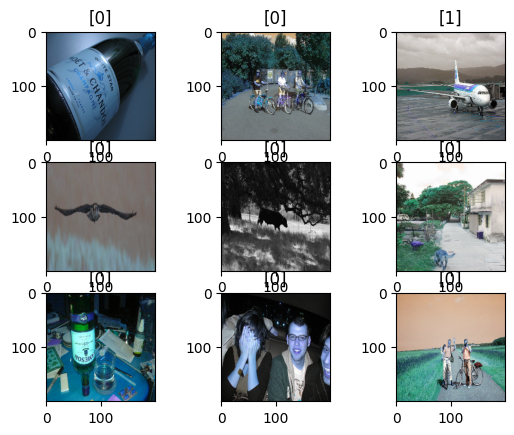

In [156]:
predict_labels = np.round(pred_test).astype(int)

for i in range(9):
    plt.subplot(3,3,i+1)
    index = random.randint(0,len(X_test))
    plt.imshow(X_test[index])
    plt.title(predict_labels[index])

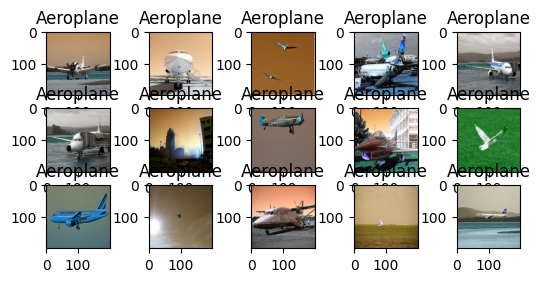

In [159]:
aeroplane_found_indices = np.where(predict_labels == 1)[0]

num_images_to_display = min(len(aeroplane_found_indices), 15)

for i, j in enumerate(aeroplane_found_indices[:num_images_to_display]):
    plt.subplot(5, 5 , i + 1)
    plt.imshow(X_test[j])
    plt.title("Aeroplane" if predict_labels[j] else "Not an Aeroplane")
    if i + 1 >= num_images_to_display:
        break

plt.show()